In [7]:
%matplotlib inline

import imageio
import scipy.stats
import scipy.special

import numpy as np
import pandas as pd
from numpy import array as arr

import os
import re
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from astropy.io import fits

from scipy.stats import sem 
from scipy import ndimage as ndi
from scipy.optimize import curve_fit

import sys
import time

sys.path.append('./klab_python_lib/')

import klib

### Can comment below if not editing klib
%load_ext autoreload
%aimport klib
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
def expfit(t, A, gamma):
    return A*np.exp(-t*gamma)

class parsedData:
    """Wrapper for parsing HDF5 experiment file. Access original file with "raw" attribute, other attributes include keyName, keysort, fillfracs, points, rois, and roisums."""
    def __init__(self, dataAddress, fnum, roiSettings = [2, 5, 30], bgoff = (-20,30), bg_rowsub = True,
                 bglevel=10614, countsperphoton = 70, thresh = 20, plots = True, deconvolve = False, masks = 0):
        """Load in data file fnum from folder dataAddress. If setting ROI automatically, roi settings order: roi_size, filter_size, threshold. Otherwise provide full list of rois in roiSettings. Returns keySort, array of atom counts with dimensions [variation number, image number in experiment]"""
        
        exp = klib.expfile.ExpFile(dataAddress+'Raw Data\\', fnum)        
        keyName, keyVals, nreps, images = exp.key_name, exp.key, exp.reps, exp.pics
        variations = len(keyVals)
    #     print(keyVals)

        # Subtract mean of first 10 rows from all images, helps get rid of noise near CCD readout edge.
        meanimg = np.mean(images, axis=0)
        bgrow = np.mean(meanimg[0:10],axis=0)
        if bg_rowsub:
            meanimg = arr([i-bgrow for i in meanimg])
            for i in range(images.shape[0]):
                img = images[i]
                bgrow = np.mean(img[0:10],axis=0)
                img = arr([row-bgrow for row in img])
                images[i]=img      
            images=arr(images)
            bglevel = 0

        # Set ROI
        if arr(roiSettings).shape==(3,):
            rois, bgrois = klib.analysis.find_rois(meanimg, *roiSettings, bgoff, display = plots)
        elif arr(roiSettings).shape!=(3,):
            rois = roiSettings
            bgrois = [[roi[0]+bgoff[0],roi[1]+bgoff[0],roi[2]+bgoff[1],roi[3]+bgoff[1]] for roi in rois]
            if plots:
                klib.plotutil.plotrois(meanimg, rois)
        else:
            Exception(TypeError)

        if deconvolve:
            roisums = np.array(list(map(lambda image: 
                                        list(map(lambda mask:
                                                 atomVal(image[ymin-pad:ymax+pad, xmin-pad:xmax+pad], mask)-bglevel,
                                                 masks)),
                                        images)))
        else:
        # represent the roi sums as a 3-dimensional array.  Axes are variations, trials, rois.  
            roisums = np.array(list(map(lambda image: 
                                        list(map(lambda roi:
                                                 klib.analysis.get_roi_sum(image, roi, bgoff, display=False)-bglevel,
                                                 rois)),
                                        images)))

        # Nice way of sorting in multiple dimensions. TODO: better handling for arbitrary keyVal shapes.
        if len(keyVals.shape)==1:
            sort = np.argsort(keyVals)
        elif len(keyVals.shape)==2:
            sort = np.lexsort((keyVals[:,0],keyVals[:,1]))
        
        keySort = keyVals[sort]
        
        npics = (images.shape[0]//nreps)//keyVals.shape[0]
        images = images.reshape((variations, nreps, npics, images.shape[1], images.shape[2]))
        roisums = roisums.reshape(variations, nreps, npics, len(rois))
        #     roisums = roisums.reshape(variations, images.shape[0]//variations, len(rois))

        imsort = images[sort]
        roisums = roisums[sort]

        atom_thresh = thresh*countsperphoton
    #   Binarize roisums and average over reps. Axes are variation, image number in sequence, rois
        binarized = np.clip(roisums, atom_thresh, atom_thresh+1) - atom_thresh
        fill_first = np.mean(binarized[:,:,0,:], axis = (1,2))
        fill_last = np.mean(binarized[:,:,-1,:], axis = (1,2))
        fill_rois = np.mean(binarized[:,:,0,:], axis = 1)
        fillfracs = np.mean(binarized, axis = (1,2,3))
    #     print(tuple(np.arange(1, binarized.ndim)))

        points = len(rois)*nreps
        z = 1.96 # corresponds to 95% CI

        error_first = z*np.sqrt(fill_first*(1-fill_first)/points)
        error_last = z*np.sqrt(fill_last*(1-fill_last)/points)
        error = z*np.sqrt(fillfracs*(1-fillfracs)/points)
    #     lowerfrac = z*np.sqrt(fillfracs*(1-fillfracs)/points)
        self.error = error
        self.error_first = error_first
        self.error_last = error_last
        
        roi = rois[0]
        self.roiimg = meanimg[roi[2]:roi[3],roi[0]:roi[1]]
        
        self.roisums_old = roisums.reshape(variations, nreps*npics, len(rois))
        self.fillfracs = fillfracs
        self.fill_first = fill_first
        self.fill_last = fill_last
        self.fill_rois = fill_rois
        self.raw = exp
        self.keyName = keyName
        self.keySort = keySort
        self.points = points
        self.rois = rois
        self.roisums = roisums
        self.fnum = fnum
        self.thresh = thresh
        self.countsperphoton = countsperphoton
        self.binarized = binarized
        self.npics = npics
        self.nreps = nreps
        self.meanimg = meanimg
        
    def plotFill(self, plotROIs = False):
        """Plots fill fration, both for first image in each experiment, and for each individual ROI"""
        if self.keySort.ndim==1:
            plt.errorbar(self.keySort, self.fill_first, yerr = self.error_first, fmt='k-', zorder = 1)
            plt.errorbar(self.keySort, self.fillfracs, yerr = self.error, fmt='-', color="0.5", zorder = 0)
            plt.errorbar(self.keySort, self.fill_last, yerr = self.error_last, fmt='-', color="0.75", zorder = 0)
            plt.ylabel('Fill Fraction', fontsize = 14)
            plt.xlabel(self.keyName, fontsize = 14)
            plt.title("File " + str(self.fnum))
            plt.legend(['1st image', 'Average', 'Last'])
            plt.show()
#             plt.plot(self.keySort, self.fill_first, 'k-', zorder = 1)
#             plt.plot(self.keySort, self.fill_last, 'r-', zorder = 0)
#             plt.ylabel('Fill Fraction', fontsize = 14)
#             plt.xlabel(self.keyName, fontsize = 14)
#             plt.title("File " + str(self.fnum))
#             plt.legend(['1st image', 'Average', 'Last'])
#             plt.show()
            print('average fill fraction: ' + str(np.mean(self.fill_first)))
            z = 1.96 # corresponds to 95% CI

            if plotROIs:
                for i in range(len(rois)):
                    fill_roi = self.fill_rois[:,i]
                    error_roi = z*np.sqrt(fill_roi*(1-fill_roi)/self.points)
                    plt.errorbar(self.keySort, fill_roi, yerr = error_roi, fmt='-', zorder = 1)
                plt.ylabel('Fill Fraction', fontsize = 14)
                plt.xlabel(self.keyName, fontsize = 14)
                plt.title("File " + str(self.fnum))
                plt.legend(range(len(self.rois)))
                plt.show()
        elif self.keySort.ndim==2:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.keySort[:,0], self.keySort[:,1], self.fill_first, c = 'b', marker='o')
            ax.set_xlabel(self.keyName[0])
            ax.set_ylabel(self.keyName[1])
            ax.set_zlabel('Fill Fraction')
            ax.set_title("File " + str(self.fnum))
            plt.show()
    
    
    def plotTimeFill(self, plotROIs = False):
        """Plots fill fration, both for first image in each experiment, and for each individual ROI"""
        
        if self.roisums.shape[0]!=1:
            raise ValueError('Cannot plot fill per cycle with variations.')
        roisums = self.roisums[0].reshape(self.nreps, self.npics//2, 2, len(self.rois))
        roisums = roisums.swapaxes(0,1)
            
        atom_thresh = self.thresh*self.countsperphoton
        binarized = np.clip(roisums, atom_thresh, atom_thresh+1) - atom_thresh        
        # binarized: (npair, nrep, pair, rois)
        fill_first = np.mean(binarized[:,:,0,:], axis = (1,2))
        fill_last = np.mean(binarized[:,:,-1,:], axis = (1,2))
        fill_rois = np.mean(binarized[:,:,0,:], axis = 1)
        fillfracs = np.mean(binarized, axis = (1,2,3))
    #     print(tuple(np.arange(1, binarized.ndim)))

        z = 1.96 # corresponds to 95% CI
        error_first = z*np.sqrt(fill_first*(1-fill_first)/self.points)
        error = z*np.sqrt(fillfracs*(1-fillfracs)/self.points)
        error_last = z*np.sqrt(fill_last*(1-fill_last)/self.points)
        
        pairs = np.arange(self.npics//2)
        popt, pcov = curve_fit(expfit, pairs, fill_first)
        
        plt.errorbar(range(self.npics//2), fill_first, yerr = error_first, fmt='k-', zorder = 1)
        plt.errorbar(range(self.npics//2), fillfracs, yerr = error, fmt='-', color="0.5", zorder = 0)
        plt.errorbar(range(self.npics//2), fill_last, yerr = error_last, fmt='-', color="0.75", zorder = 0)
        plt.ylabel('Fill Fraction', fontsize = 14)
        plt.xlabel("Cycle number", fontsize = 14)
        plt.xticks(range(roisums.shape[0]))
        plt.title("File " + str(self.fnum))
        plt.legend(['1st image', 'Average', 'Last'])
        plt.plot(pairs, expfit(pairs, *popt))
        plt.show()
        print('decay rate: ' + str(popt[1]) + ' +- ' + str(np.sqrt(pcov[1][1])))
        if plotROIs:
            for i in range(len(rois)):
                fill_roi = fill_rois[:,i]
                error_roi = z*np.sqrt(fill_roi*(1-fill_roi)/self.points)
                plt.errorbar(range(self.pairsPerRep), fill_roi, yerr = error_roi, fmt='-', zorder = 1)
            plt.ylabel('Fill Fraction', fontsize = 14)
            plt.xlabel("Cycle number", fontsize = 14)
            plt.xticks(range(roisums.shape[0]))
            plt.title("File " + str(self.fnum))
            plt.legend(range(len(self.rois)))
            plt.show()
            
    def hist(self, countsperphoton = "Default", thresh = "Default", rng = None):
        """Wrapper for hist_stats, will default to thresholds and counts per photon used when creating parsedData object, but can also manually specify values."""
        if countsperphoton == "Default":
            countsperphoton = self.countsperphoton
        if thresh == "Default":
            thresh = self.thresh
        print("Current File: " + str(self.fnum))
        return klib.analysis.hist_stats(self.roisums, thresh = thresh, countsperphoton = countsperphoton, rng=rng)
        
    def getLossData(self, indroi = False, plots = False, timeOrdered = False):
        """Returns sorted keyvals, loss between pairs of images in experiment, and error in that measurement, in that order. If data from individual roi is wanted, specify which roi number with indroi input."""
        
        if timeOrdered:
            if self.roisums.shape[0]!=1:
                raise ValueError('Cannot plot fill per cycle with variations.')
            roisums = self.roisums[0].reshape(self.nreps, self.npics//2, 2, len(self.rois))
            roisums = roisums.swapaxes(0,1)
            ks = range(roisums.shape[0])
        else:
            roisums = self.roisums
            ks = self.keySort
        losses =[]
        losserrs = []
        infids = []
        for var in range(roisums.shape[0]):
            if not indroi:
                infidelity, inf_err, lossfrac, loss_err = klib.analysis.hist_stats(roisums, i=var, thresh = self.thresh, countsperphoton = self.countsperphoton, quiet = True, plots = plots)
            else:
                infidelity, inf_err, lossfrac, loss_err = klib.analysis.hist_stats(roisums, i=var, thresh = self.thresh, countsperphoton = self.countsperphoton, roinum = indroi, quiet = True, plots = plots)
            losses.append(lossfrac)
            infids.append(infidelity)
            losserrs.append(loss_err)
            
        return ks, arr(losses), arr(losserrs)
    
    def plotLosses(self):
        ks, losses, losserrs = self.getLossData()
        plt.errorbar(self.keySort, losses, yerr=losserrs, fmt = 'r-')
        plt.plot(self.keySort, losses, 'k.')
        plt.xlabel(self.keyName)
        plt.ylabel('losses')
        plt.title("File " + str(self.fnum))
        plt.axis([min(self.keySort), max(self.keySort), 0, 100])
        plt.show()

    def plotIndLosses(self):
        centers = []
        errors = []
        for roinum in range(len(self.rois)):
            losses =[]
            losserrs = []
            infids = []
            for var in range(roisums.shape[0]):
                infidelity, inf_err, lossfrac, loss_err = klib.analysis.hist_stats(self.roisums,i=var, thresh = self.thresh, countsperphoton = self.countsperphoton, roinum = roinum, quiet = True, plots = False)
                losses.append(lossfrac)
                infids.append(infidelity)
                losserrs.append(loss_err)
            popt, perr = klib.mathutil.gausfit(ks, losses,y_offset=True, negative=True)
            xs = np.linspace(np.min(ks), np.max(ks), 100)
            plt.plot(xs, klib.mathutil.gaussian(xs, *popt), 'r-')
            centers.append(popt[0])
            errors.append(perr[0])
            #plt.errorbar(self.keySort, losses, yerr=losserrs)
            plt.xlabel(self.keyName)
            plt.ylabel('losses')
            plt.axis([min(xs), max(xs), 0, 100])
            plt.show()
        return centers, errors
    
    def plotTimeLosses(self):
        cycs, losses, losserrs = self.getLossData(timeOrdered = True)
        plt.errorbar(cycs, losses, yerr=losserrs, fmt = 'r-')
        plt.xlabel('Cycle number')
        plt.ylabel('Losses')
        plt.title("File " + str(self.fnum))
        plt.axis([cycs[0], cycs[-1], 0, 100])
        plt.xticks(cycs)
        plt.show()

    def fitIndividualData(self):
        centers = []

        for roinum in range(len(rois)):
            losses = []
            losserrs = []
            infids = []
            
            for var in range(roisums.shape[0]):
                    infidelity, inf_err, lossfrac, loss_err = klib.analysis.hist_stats(self.roisums,i=var, thresh = self.thresh, countsperphoton = self.countsperphoton, roinum = roinum, quiet = True)
                    losses.append(lossfrac)
                    infids.append(infidelity)
                    losserrs.append(loss_err)
            plt.errorbar(self.keySort, losses, yerr=losserrs)
            plt.xlabel('scan parameter')
            plt.ylabel('losses')
            plt.axis([np.min(self.keySort), np.max(self.keySort), 0, 100])
            plt.show()
            p_guess = [ks[np.argmax(losses)], np.max(losses), .0001, 0]
#             popt, pcov = curve_fit(klib.mathutil.gaussian, ks, losses, p0 = p_guess, maxfev=100000)   
            
            popt, perr = klib.mathutil.gausfit(ks, losses,y_offset=True, negative=True)
            
            xs = np.linspace(np.min(ks), np.max(ks), 100)
            plt.plot(ks, losses, 'k-')
            plt.plot(ks, losses, 'k.')
            plt.plot(xs, klib.mathutil.gaussian(xs, *popt), 'r-')
            plt.xlabel(data.keyName)
            plt.ylabel('losses')
            
            plt.axvline(x=popt[0], ymin=0, ymax = 100, linewidth=2, color='b')
            
            print("Current file: ", current)
            plt.show()

            print('center frequency: ' + str(popt[0]) + ' MHz')
            print('width: ' + str(1000000*popt[2]) + 'Hz')
            centers.append(popt[0]*1000000)
        print(centers)
        plt.plot(range(len(centers)), centers-np.mean(centers), 'ko')
        plt.xlabel('trap number')
        plt.ylabel('center deviation (Hz)')
        
    def fitSpot(self, magnification = ((16*10**-6)*(22*10**-3)/(1000*10**-3)*10**9)):
        img = self.roiimg
        fitdat, params, perr = klib.mathutil.gaussianBeamFit2D(img)
        plt.imshow(img)
        plt.contour(fitdat)
        plt.show()
        print("Waists (nm): " + str(params[-3:-1]*magnification))

In [9]:
from skimage import restoration
from skimage.feature import peak_local_max
from skimage import img_as_float

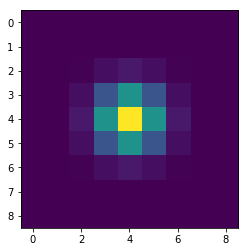

In [323]:
def psf(x, w):
    return np.exp(-2*(x**2)/w)

def psfSum(x, y, w, x0s, y0s, amps):
    n = len(x0s)
    ampout = sum([amps[i]*psf(np.sqrt((x-x0s[i])**2+(y-y0s[i])**2), w) for i in range(n)])
    return ampout

def deconvolve(img, w, iters):
    a = round(w)
    x = np.arange(-a+1,a)
    y = np.arange(-a+1,a)
    
    xx, yy = np.meshgrid(x, y)
    psfM = psf(np.sqrt(xx**2+yy**2), w)
    
    img = img - img.min()
    norm = np.max(img)
    img = img/norm
    
    imgRL = restoration.richardson_lucy(img, psfM, iterations=iters)*norm
    return imgRL

def wrapper(M, *amps):
    """Example usage: popt, pcov = curve_fit(wrapper, (xx, yy), mimg.ravel(), p0 = ones*np.mean(mimg))"""
    x, y = M
    return psfSum(x, y, 4, x0s, y0s, amps).ravel()

x = np.arange(-4,5)
y = np.arange(-4,5)

xx, yy = np.meshgrid(x, y)

psfM = psf(np.sqrt(xx**2+yy**2), 3)

plt.imshow(psfM)
plt.show()

Current file:  50


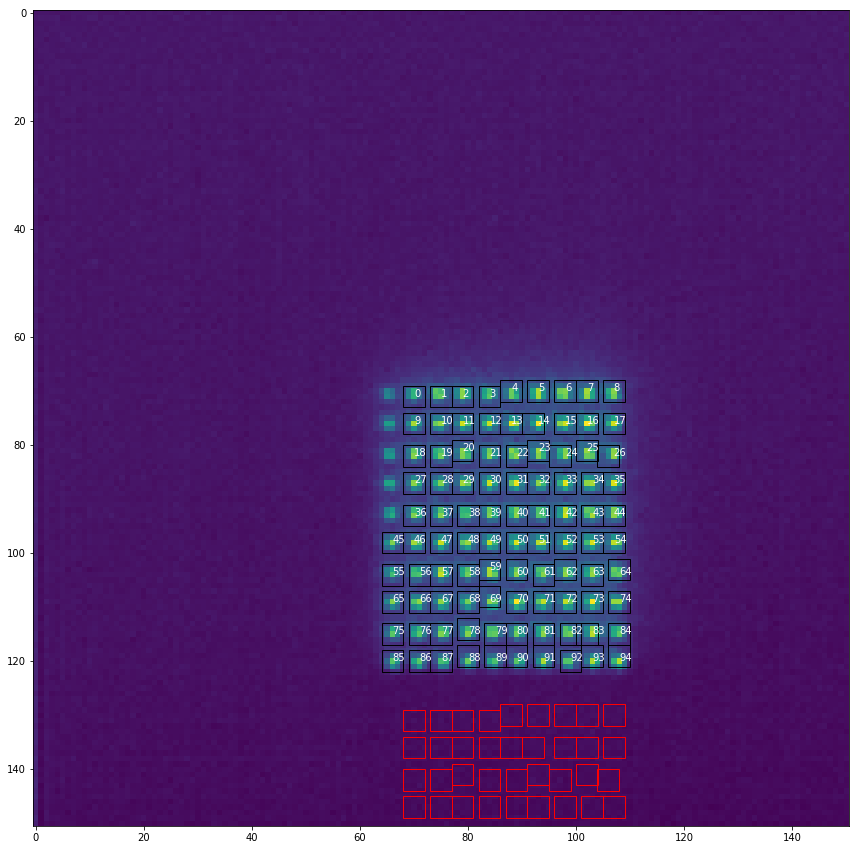

Peaks found:95
Current File: 50


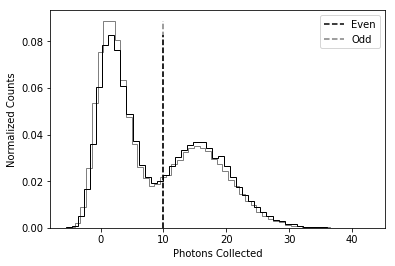

total pairs: 47457
atom atom: 17098
void void: 25574
atom void: 3073
void atom: 1712
17098 25574 3073
average infidelity: 3.61 += 0.09 percent
losses: 6.75 += 0.225726338847 percent
even/odd thresholds:  10 10


In [272]:
#autoreload
dataAddress = '..\\190703\\'
names = os.listdir(dataAddress+"Raw Data\\")
current = max([int((i.replace("data_","")).replace(".h5","")) for i in names])
# current = 48
# current = current -1
print("Current file: ", current)

cpp = 70 # Counts per photon
th = 10 # Atom threshold (# photons)

data = parsedData(dataAddress, current, roiSettings = [2,3,50], countsperphoton = cpp, thresh = th, bgoff = (0, 60))
ks, cts, pts, rois, roisums, roiimg = data.keySort, data.fillfracs, data.points, data.rois, data.roisums, data.roiimg

infidelity, inf_err, lossfrac, loss_err = data.hist()

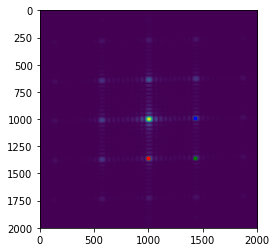

In [274]:
xmin = arr(rois)[:,0].min()
xmax = arr(rois)[:,1].max()
ymin = arr(rois)[:,2].min()
ymax = arr(rois)[:,3].max()

mimg = data.meanimg
# mimg = img - img.min()

# norm = np.max(img)
# img = img/norm
pad = 2
mimg = mimg[ymin-pad:ymax+pad, xmin-pad:xmax+pad]
# img = ndi.filters.gaussian_filter(img,1)

fftN = 2000

fimg = np.fft.fft2(mimg, s = (fftN,fftN))
fimg = np.fft.fftshift(fimg)
fimgAbs = np.abs(fimg)
fimgArg = np.angle(fimg)

# fimgMax = ndi.maximum_filter(fimg, size = 100, mode = 'constant')
fMaxCoord = peak_local_max(fimgAbs, min_distance=100, threshold_rel=.1)
# fMaxBool = peak_local_max(fimgAbs, min_distance=100, threshold_rel=.1, num_peaks = 4, indices=False)

fMaxCoord = fMaxCoord[fMaxCoord.sum(axis=1)-fftN>fftN/10] # Restrict to positive quadrant

xsort = np.argsort(fMaxCoord[:,1])
ysort = np.argsort(fMaxCoord[:,0])
xpeak, ypeak = fMaxCoord[xsort[0]], fMaxCoord[ysort[0]]

plt.imshow(fimgAbs)
plt.plot(fMaxCoord[:,1], fMaxCoord[:,0],'g.')
# plt.plot([xpeak[0], ypeak[0]],[xpeak[1],ypeak[1]],'r.')
plt.plot([xpeak[1]],[xpeak[0]],'r.')
plt.plot([ypeak[1]],[ypeak[0]],'b.')
# plt.plot(0,1000,'r.')

plt.show()

freqs = np.fft.fftfreq(fftN)
freqs = np.fft.fftshift(freqs)
fx, fy = freqs[xpeak], freqs[ypeak]
dx, dy = 1/fx, 1/fy
# dx = arr([dx[1]/dy[0], dx[1]]) 
# dy = arr([dy[0],dy[0]/dy[1]]) 

phix, phiy = fimgArg[xpeak[0], xpeak[1]], fimgArg[ypeak[0], ypeak[1]]

# if phix<0:
#     phix = -phix
# if phiy<0:
#     phiy = -phiy

normX = np.sqrt(np.sum(fx**2))
dx = (1/normX)*(fx/normX)

normY = np.sqrt(np.sum(fy**2))
dy = (1/normY)*(fy/normY)

# dx[1]=-dx[1]
# dy[0]=-dy[0]

In [275]:
dx[1]=-dx[1]
dy[0]=-dy[0]

In [276]:
tmp = dy[0]
dy[0] = dx[1]
dx[1] = tmp

In [277]:
dx, dy

(array([ 5.52481972,  0.09685647]), array([-0.01526193,  4.6383487 ]))

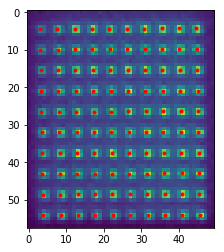

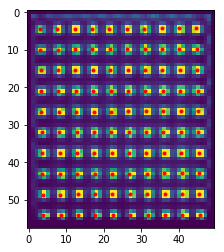

In [278]:
w = 6
iters = 20
N = 10
ns = np.arange(N)

px = arr([(dx*ind) for ind in ns])
py = arr([(dy*ind) for ind in ns])
    
pts = arr([(x + py)+[(2*np.pi-phix)/(2*np.pi*normX), (2*np.pi-phiy)/(2*np.pi*normY)] for x in px]).reshape((N**2,2))

plt.imshow(mimg)
plt.plot(pts[:,1],pts[:,0],'r.')
plt.show()

plt.imshow(deconvolve(mimg, w, iters))
plt.plot(pts[:,1],pts[:,0],'r.')
plt.show()

In [263]:
def atomVal(img, mask):
    return np.sum(mask*deconvolve(img, w, iters))

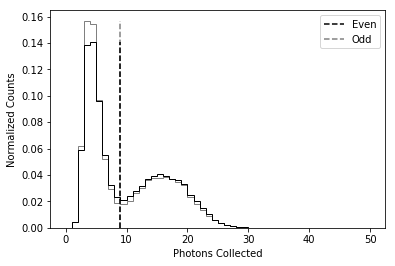

total pairs: 50000
atom atom: 20136
void void: 26287
atom void: 2407
void atom: 1170
20136 26287 2407
average infidelity: 2.34 += 0.07 percent
losses: 5.49 += 0.19966232453 percent
even/odd thresholds:  9 9


(2.3399999999999999,
 0.070000000000000007,
 5.4900000000000002,
 0.19966232453019273)

In [281]:
wmask = 3

images = data.raw.get_pics()

x = np.arange(len(mimg[0]))
y = np.arange(len(mimg[:,0]))

xx, yy = np.meshgrid(x, y)

masks = arr([psf(np.sqrt((xx-pts[i,1])**2+(yy-pts[i,0])**2), wmask) for i in range(len(pts))])

dat = []

for img in images:
    img = img[ymin-pad:ymax+pad, xmin-pad:xmax+pad]-np.mean(img)
    dimg = deconvolve(img, w, iters)
    dat.append(np.sum(masks*dimg, axis = (1,2)))

dat = arr(dat).reshape(1, data.nreps, data.npics, len(masks))
klib.analysis.hist_stats(dat, thresh = 9, countsperphoton = 70, rng = (0,50))

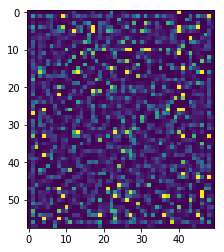

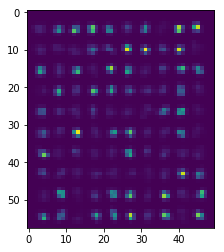

In [331]:
plt.imshow(np.sum(masks, axis=0))
plt.show()

plt.imshow(mimg)
plt.show()

plt.imshow(img)
plt.show()

plt.imshow(dimg)
plt.show()

plt.imshow(dimg*np.sum(masks, axis=0))
plt.show()

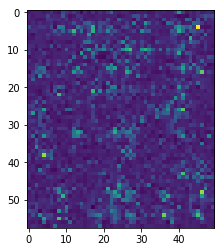

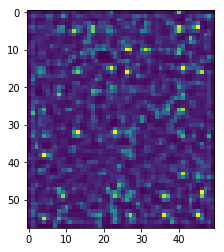

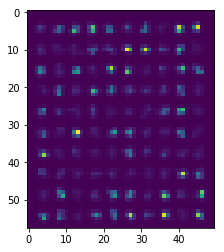

In [385]:
dimg = deconvolve(img, 3, 10)

plt.imshow(img)
plt.show()

plt.imshow(dimg)
plt.show()

plt.imshow(dimg*np.sum(masks, axis=0))
plt.show()

Current file:  45


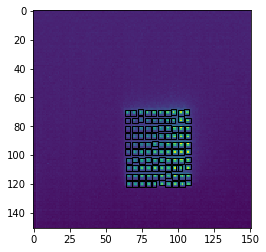

KeyboardInterrupt: 

In [268]:
#autoreload
dataAddress = '..\\190703\\'
names = os.listdir(dataAddress+"Raw Data\\")
current = max([int((i.replace("data_","")).replace(".h5","")) for i in names])
current = 45
# current = current -1
print("Current file: ", current)

cpp = 70 # Counts per photon
th = 10 # Atom threshold (# photons)

data = parsedData(dataAddress, current, roiSettings = rois, countsperphoton = cpp, thresh = th, bgoff = (0, 60), deconvolve = True, masks = masks)
ks, cts, pts, rois, roisums, roiimg = data.keySort, data.fillfracs, data.points, data.rois, data.roisums, data.roiimg

infidelity, inf_err, lossfrac, loss_err = data.hist()